# Covid19 vaccination rate in different countries
Ironhack project 4<br>
by Jet Salomons

In this project I look if the vaccination rate in countries might be correlated with different country-level variables. Our World in Data (amongst others) already has very nice analyses about for example vaccination rate and total covid cases, GDP per capita, poverty etc. I will therefore look at some less researched variables. 

The project revolves around hypothesis testing with a focus on t-tests and confidence intervals.

### THE DATA
Can you see differences in mean vaccination rate of countries that differ in:
<ol>
    <li><b> Corruption (CPI)</b></li>
    <ul><li>low values where corruption is high.</li></ul><br>
    <li><b> Inequality (GINI)</b> </li>
    <ul><li>score of 1 (or 100%): 1 person owns all the wealth while the others own nothing</li></ul>
    <ul><li>score of 0: wealth is distributed the evenly across all people</li></ul><br> 
    <li><b> percentage of GDP spent on healthcare (2018) </b></li><br>
    <li><b> Vaccin brands available</b></li>
    <ul><li>some vaccins are more trusted than others. Does the availability of certain types of vaccins have an effect on vaccination rate</li></ul><br>
    <li><b> Governance</b></li>
    <ul><li> for example parliamentary democracy, sultanate etc</li></ul><br>
    </ol>

Unfortunately, I did not have enough time to sort out the last variable.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import t
from scipy.stats import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

## General inspection of the data

In [2]:
covid = pd.read_csv('./data/covid.csv')
covid.head()

,country,ISO3,continent,total_cases,total_cases_per_million,total_deaths_per_million,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,stringency_index,...,CoVaxin,CanSino,EpiVacCorona,pop_dens_2018,Year_GINI,GINI,Region,CPI score 2020,HealthCare_GDP,nr_vaccins
0,Afghanistan,AFG,Asia,7.306571e+04,1876.928714,76.492000,1.575000,1.235000,0.340000,37.96,...,0.0,0.0,0.0,56.937760,NaN,NaN,AP,19.0,9.395727,3.0
1,Africa,OWID_AFR,NaN,4.853711e+06,3620.556000,97.672429,2.467143,1.837143,0.624286,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,Albania,ALB,Europe,1.323344e+05,45984.581429,851.543143,27.072500,16.927500,10.145000,NaN,...,0.0,0.0,0.0,104.612263,2017.0,33.2,ECA,36.0,5.262714,4.0
3,Algeria,DZA,Africa,1.293270e+05,2949.234286,79.385714,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,17.730068,2011.0,27.6,MENA,36.0,6.218427,1.0
4,Andorra,AND,Europe,1.372800e+04,177674.238143,1643.694000,46.480000,35.740000,10.750000,43.52,...,0.0,0.0,0.0,163.842553,NaN,NaN,NaN,NaN,6.710331,2.0


In [3]:
covid.columns

Index(['country', 'ISO3', 'continent', 'total_cases',
       'total_cases_per_million', 'total_deaths_per_million',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'stringency_index', 'population',
       'population_density', 'gdp_per_capita', 'extreme_poverty',
       'human_development_index', 'system', 'system_extra', 'Vaccines',
       'Sputnik', 'Sinopharm', 'Sinovac', 'AstraZeneca', 'QazVac', 'Pfizer',
       'Dimer', 'Moderna', 'Johnson', 'Abdala', 'Soberana', 'CoVaxin',
       'CanSino', 'EpiVacCorona', 'pop_dens_2018', 'Year_GINI', 'GINI',
       'Region', 'CPI score 2020', 'HealthCare_GDP', 'nr_vaccins'],
      dtype='object')

I won't use all columns, so I'll delete the ones that I don't need and give them shorter names

In [4]:
covid = covid[['country', 'ISO3', 'continent', 'Region', 'system', 'gdp_per_capita', 'people_vaccinated_per_hundred', 'stringency_index', 'nr_vaccins',
       'Sputnik', 'Sinopharm', 'Sinovac', 'AstraZeneca', 'QazVac', 'Pfizer',
       'Dimer', 'Moderna', 'Johnson', 'Abdala', 'Soberana', 'CoVaxin',
       'CanSino', 'EpiVacCorona', 'Year_GINI', 'GINI', 'CPI score 2020', 'HealthCare_GDP']]

In [5]:
covid.columns = ['country', 'ISO3', 'continent','region','system', 'GDP', 'vacc_100', 'strictness', 'nr_vaccins',
       'Sputnik', 'Sinopharm', 'Sinovac', 'AstraZeneca', 'QazVac', 'Pfizer',
       'Dimer', 'Moderna', 'Johnson', 'Abdala', 'Soberana', 'CoVaxin',
       'CanSino', 'EpiVacCorona',  'year_GINI', 'GINI',  'CPI', 'HCare_GDP']

### Check out the dataframe for obvious errors / weird things

In [6]:
#check the data: what do we have at hand?
print(covid.shape)

#298 rows whils there are 195 countries in the world. That's strange to say the least. Investigate a little further.

(298, 27)


In [7]:
list(covid["country"]) 
#all kinds of regions (like south Asia, OECD members etc) are in the dataframe. Makes it a lot longer

['Afghanistan',
 'Africa',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Asia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Cook Islands',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czechia',
 'Democratic Republic of Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Europe',
 'European Union',
 'Faeroe Islands',
 'Fiji',
 'Finland',
 'France',
 'French Polynesia',
 'Ga

### Select countries that have value for parameter of interest: vaccination per 100 inhabitants

In [8]:
covid = covid[covid["vacc_100"].notna()]
len(covid)

170

In [9]:
#FOR PRESENTATION PURPOSE: SHOW WHAT DATA LOOKS LIKE 
covid[['country', 'region','vacc_100','GINI',  'CPI', 'HCare_GDP', 'GDP', 'Sputnik', 'Sinopharm', 'Sinovac', 'AstraZeneca', 'QazVac', 'Pfizer',
       'Dimer', 'Moderna', 'Johnson', 'CanSino', 'EpiVacCorona']].head(10)

,country,region,vacc_100,GINI,CPI,HCare_GDP,GDP,Sputnik,Sinopharm,Sinovac,AstraZeneca,QazVac,Pfizer,Dimer,Moderna,Johnson,CanSino,EpiVacCorona
0,Afghanistan,AP,1.235000,NaN,19.0,9.395727,1803.987,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Africa,NaN,1.837143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,ECA,16.927500,33.2,36.0,5.262714,11803.431,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,Andorra,NaN,35.740000,NaN,NaN,6.710331,NaN,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,Angola,SSA,2.070000,51.3,27.0,2.549005,5819.495,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Antigua and Barbuda,NaN,34.143333,NaN,NaN,5.231559,21490.943,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Argentina,AME,21.562857,42.9,42.0,9.624540,18933.907,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Armenia,ECA,1.130000,29.9,49.0,10.025390,8787.580,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Aruba,NaN,59.440000,NaN,NaN,NaN,35973.781,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10,Asia,NaN,6.075714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Check out the number of observations per column
With variables from different sources, the number of countries for which each variable is available differs aswell. Look at the shape of the entire dataframe and eyeball the counts for the individual columns.

In [10]:
print(covid.shape)
pd.set_option('display.max_columns', None)
covid.describe() #look at count in table

(170, 27)


,GDP,vacc_100,strictness,nr_vaccins,Sputnik,Sinopharm,Sinovac,AstraZeneca,QazVac,Pfizer,Dimer,Moderna,Johnson,Abdala,Soberana,CoVaxin,CanSino,EpiVacCorona,year_GINI,GINI,CPI,HCare_GDP
count,147.000000,170.000000,91.000000,170.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.0,162.000000,162.000000,162.000000,162.000000,162.0,162.000000,162.000000,117.000000,117.000000,136.000000,140.000000
mean,21404.857095,22.085175,55.791839,2.241176,0.191358,0.253086,0.160494,0.802469,0.006173,0.524691,0.0,0.246914,0.135802,0.006173,0.006173,0.0,0.012346,0.006173,2016.769231,37.082906,45.602941,6.669318
std,21320.549451,20.796128,15.810830,1.285126,0.394590,0.436128,0.368202,0.399371,0.078567,0.500938,0.0,0.432553,0.343641,0.078567,0.078567,0.0,0.110766,0.078567,2.048484,7.482604,19.267043,2.890509
min,661.240000,0.030000,11.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2011.000000,24.600000,12.000000,1.597385
25%,5622.558000,3.615000,44.905000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2016.000000,31.900000,30.750000,4.500895
50%,14600.861000,15.819000,56.480000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2018.000000,35.700000,40.000000,6.544414
75%,30777.996000,37.400000,68.055000,3.000000,0.000000,0.750000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2018.000000,41.600000,60.000000,8.370488
max,116935.600000,116.025000,85.190000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,2019.000000,59.100000,88.000000,19.047359


#### Strictness is not well recorded (lot of missing observations), HCare_GDP also has quite some missing values. Lets see what kind of countries that are
Weird combination of countries like Yemen, Libya, Greenland and Liechtenstein. Can't really make up an general estimation for this group of countries so will just let that be.

In [11]:
covid[["country", "HCare_GDP"]].sort_values(by=["HCare_GDP", "country"]).tail(30)

,country,HCare_GDP
1,Africa,NaN
9,Aruba,NaN
10,Asia,NaN
22,Bermuda,NaN
36,Cayman Islands,NaN
44,Cook Islands,NaN
49,Curacao,NaN
65,Europe,NaN
66,European Union,NaN
67,Faeroe Islands,NaN


### There are countries with 0 vaccins. Lets check these out.

In [12]:
covid[covid["nr_vaccins"]==0] 
#ah, these are the regions.. will not delete them for now, they're not too disturbing

,country,ISO3,continent,region,system,GDP,vacc_100,strictness,nr_vaccins,Sputnik,Sinopharm,Sinovac,AstraZeneca,QazVac,Pfizer,Dimer,Moderna,Johnson,Abdala,Soberana,CoVaxin,CanSino,EpiVacCorona,year_GINI,GINI,CPI,HCare_GDP
1,Africa,OWID_AFR,NaN,NaN,NaN,NaN,1.837143,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Asia,OWID_ASI,NaN,NaN,NaN,NaN,6.075714,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,Europe,OWID_EUR,NaN,NaN,NaN,NaN,32.118571,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,European Union,OWID_EUN,NaN,NaN,NaN,NaN,38.914286,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,North America,OWID_NAM,NaN,NaN,NaN,NaN,37.520000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149,Oceania,OWID_OCE,NaN,NaN,NaN,NaN,10.900000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180,South America,OWID_SAM,NaN,NaN,NaN,NaN,19.121429,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,World,OWID_WRL,NaN,NaN,NaN,15469.207,10.984286,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Check out the variables: vaccination rate and GDP per capita

### Vaccination rate

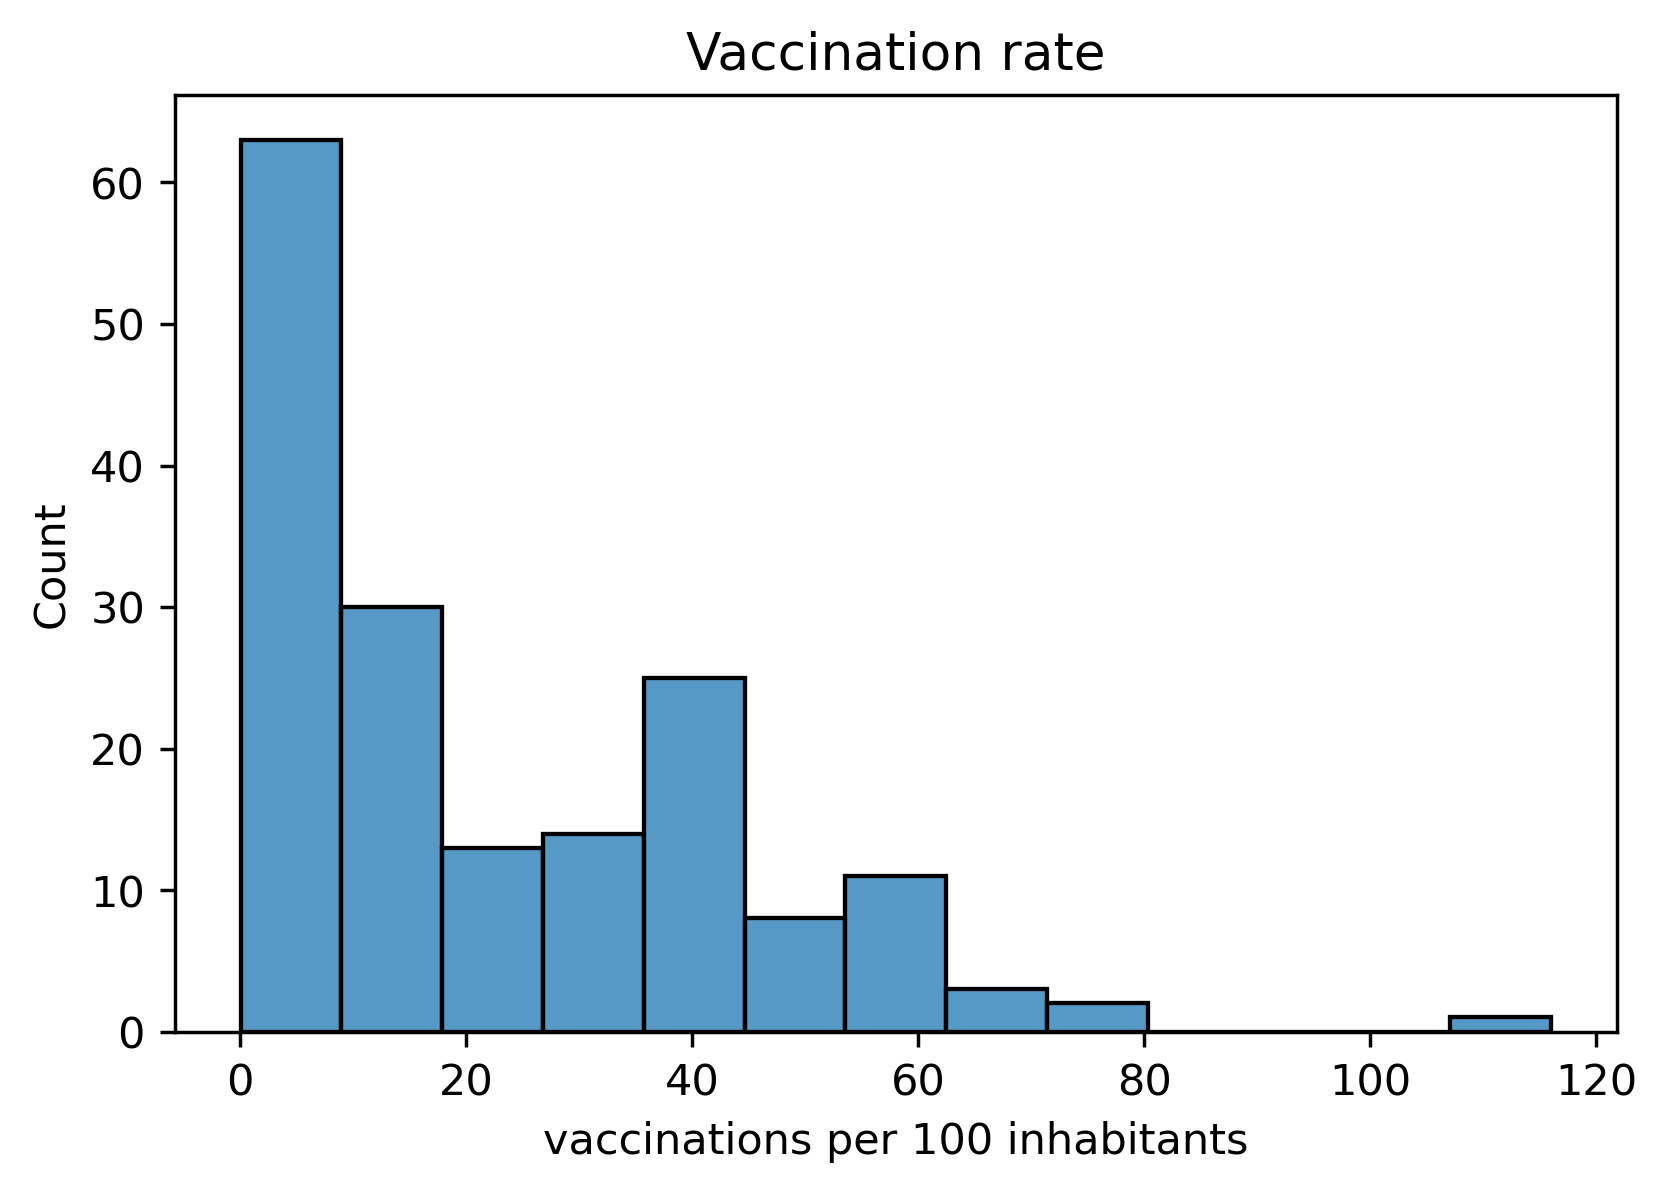

In [13]:
fig, ax = plt.subplots(1,1, dpi=310)

bins_ = int(np.sqrt(covid["vacc_100"].count()))
sns.histplot(data = covid, x="vacc_100", bins=bins_)
ax.set(xlabel="vaccinations per 100 inhabitants", title = "Vaccination rate")

plt.show()

#### Over a 100% vaccination rate?
There is a country with a vaccination-percentage above 100%. The table below shows this is Gibraltar. Some online research also shows a >100% vaccination on other websites and a news article stating that several thousand cross-border workers from Spain got vaccinated too. Which is why the percentage here in Gibraltar exceeds 100%. (114,13%) https://slate.com/news-and-politics/2021/04/gibraltar-covid-vaccination-safe.html

In [14]:
covid.sort_values("vacc_100", ascending = False).head(1) #gibraltar above 100%

,country,ISO3,continent,region,system,GDP,vacc_100,strictness,nr_vaccins,Sputnik,Sinopharm,Sinovac,AstraZeneca,QazVac,Pfizer,Dimer,Moderna,Johnson,Abdala,Soberana,CoVaxin,CanSino,EpiVacCorona,year_GINI,GINI,CPI,HCare_GDP
77,Gibraltar,GIB,Europe,NaN,parliamentary democracy (Parliament),NaN,116.025,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [15]:
covid["vacc_100"].mean()

22.085174509803924

### Per capita GDP
How countries can respond to health crises is of course dependent on how rich the countries are. Per capita GDP is a measure for this. Therefore I first have a look of the per capita GDP-data in the covid-dataframe. (note: the column in my dataframe is called GDP, for shortness sake).

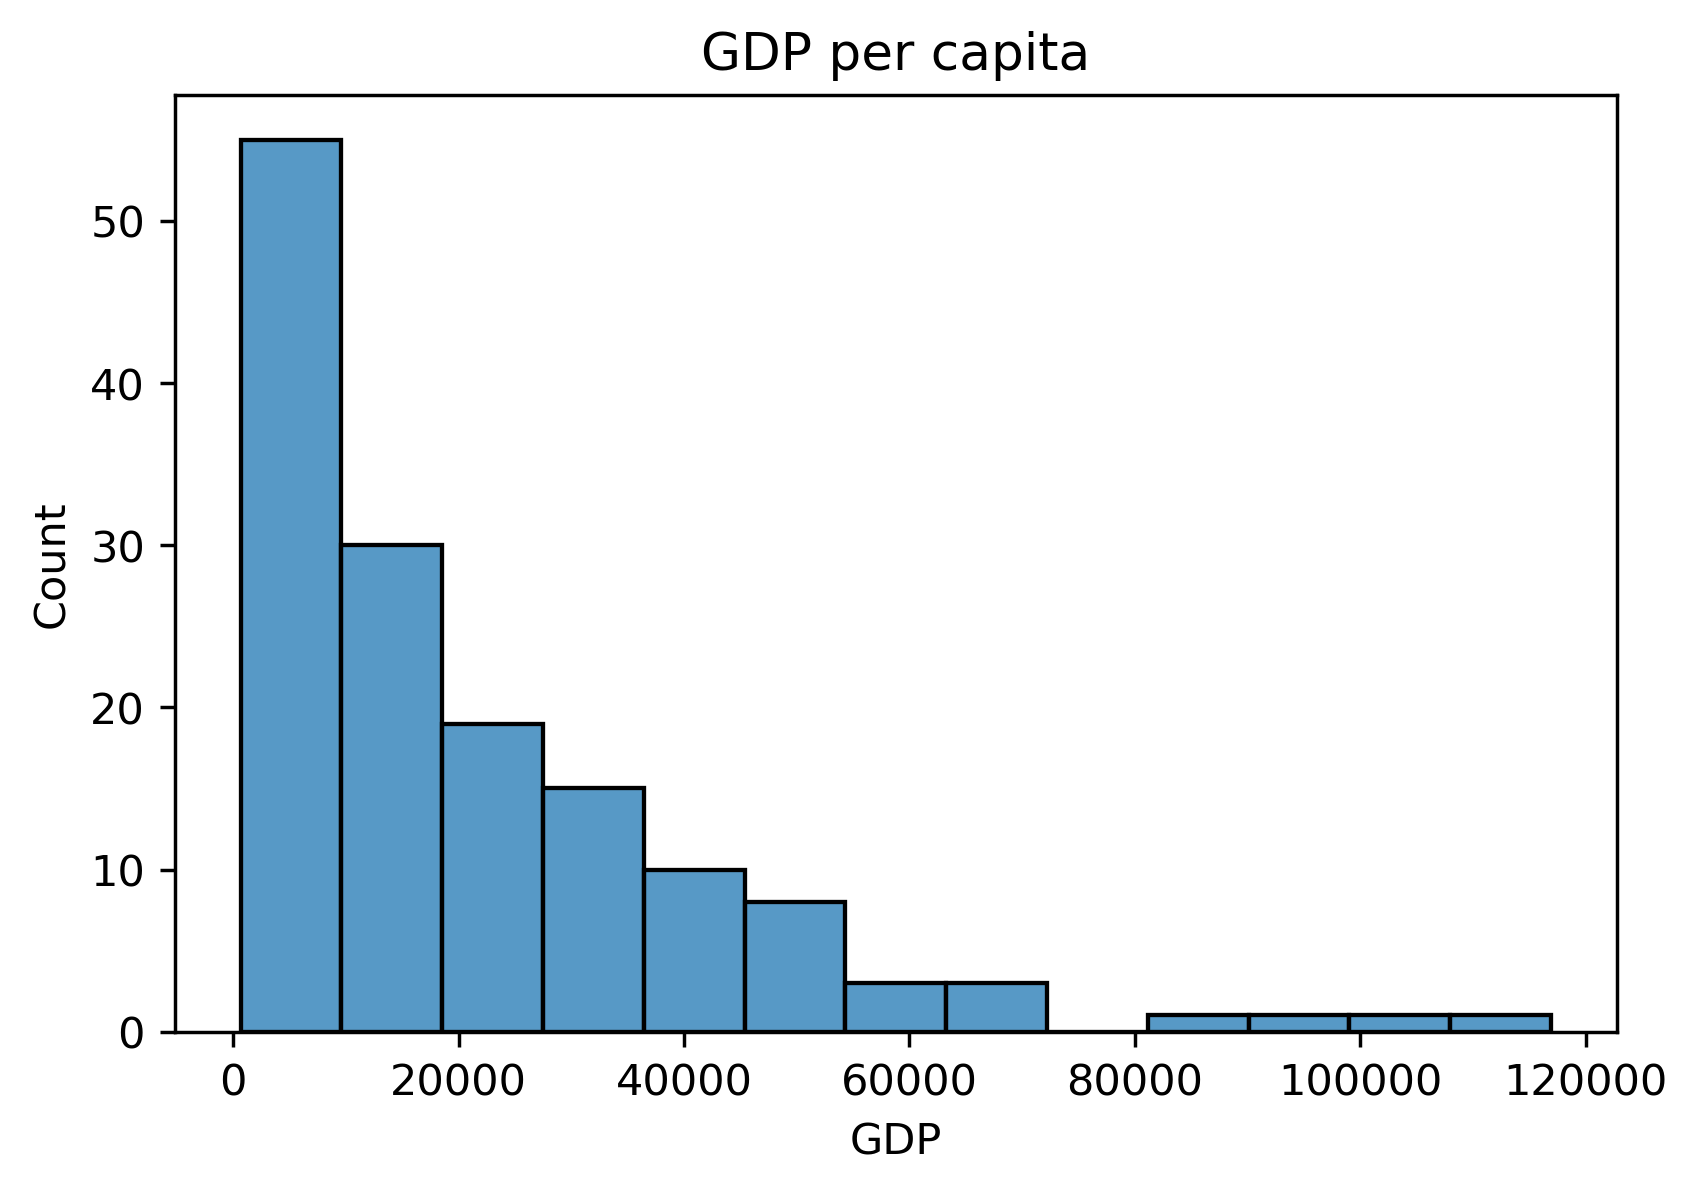

In [133]:
fig, ax = plt.subplots(1,1, dpi=310)
bin_nr= int(np.sqrt(len(covid["GDP"])))
sns.histplot(covid["GDP"], bins=bin_nr).set_title("GDP per capita") 
plt.show()

In [17]:
covid[["GDP", "country"]].sort_values(by="GDP", ascending=False).head(6) #highest GDP/capita

,GDP,country
160,116935.600,Qatar
119,104861.851,Macao
118,94277.965,Luxembourg
174,85535.383,Singapore
28,71809.251,Brunei
96,67335.293,Ireland


In [18]:
covid["LN_GDP"] = np.log(covid["GDP"]) #take the natural log, to "tuck the right tail in".

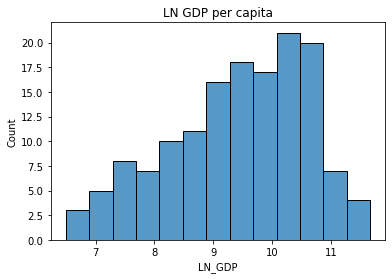

In [134]:
bin_nr= int(np.sqrt(len(covid["LN_GDP"])))
sns.histplot(covid["LN_GDP"], bins=bin_nr).set_title("LN GDP per capita") 
plt.show() 

### Corruption, inequality and healthcare

Quick scan: <br>
Is there variation?<br>
Are there outliers?

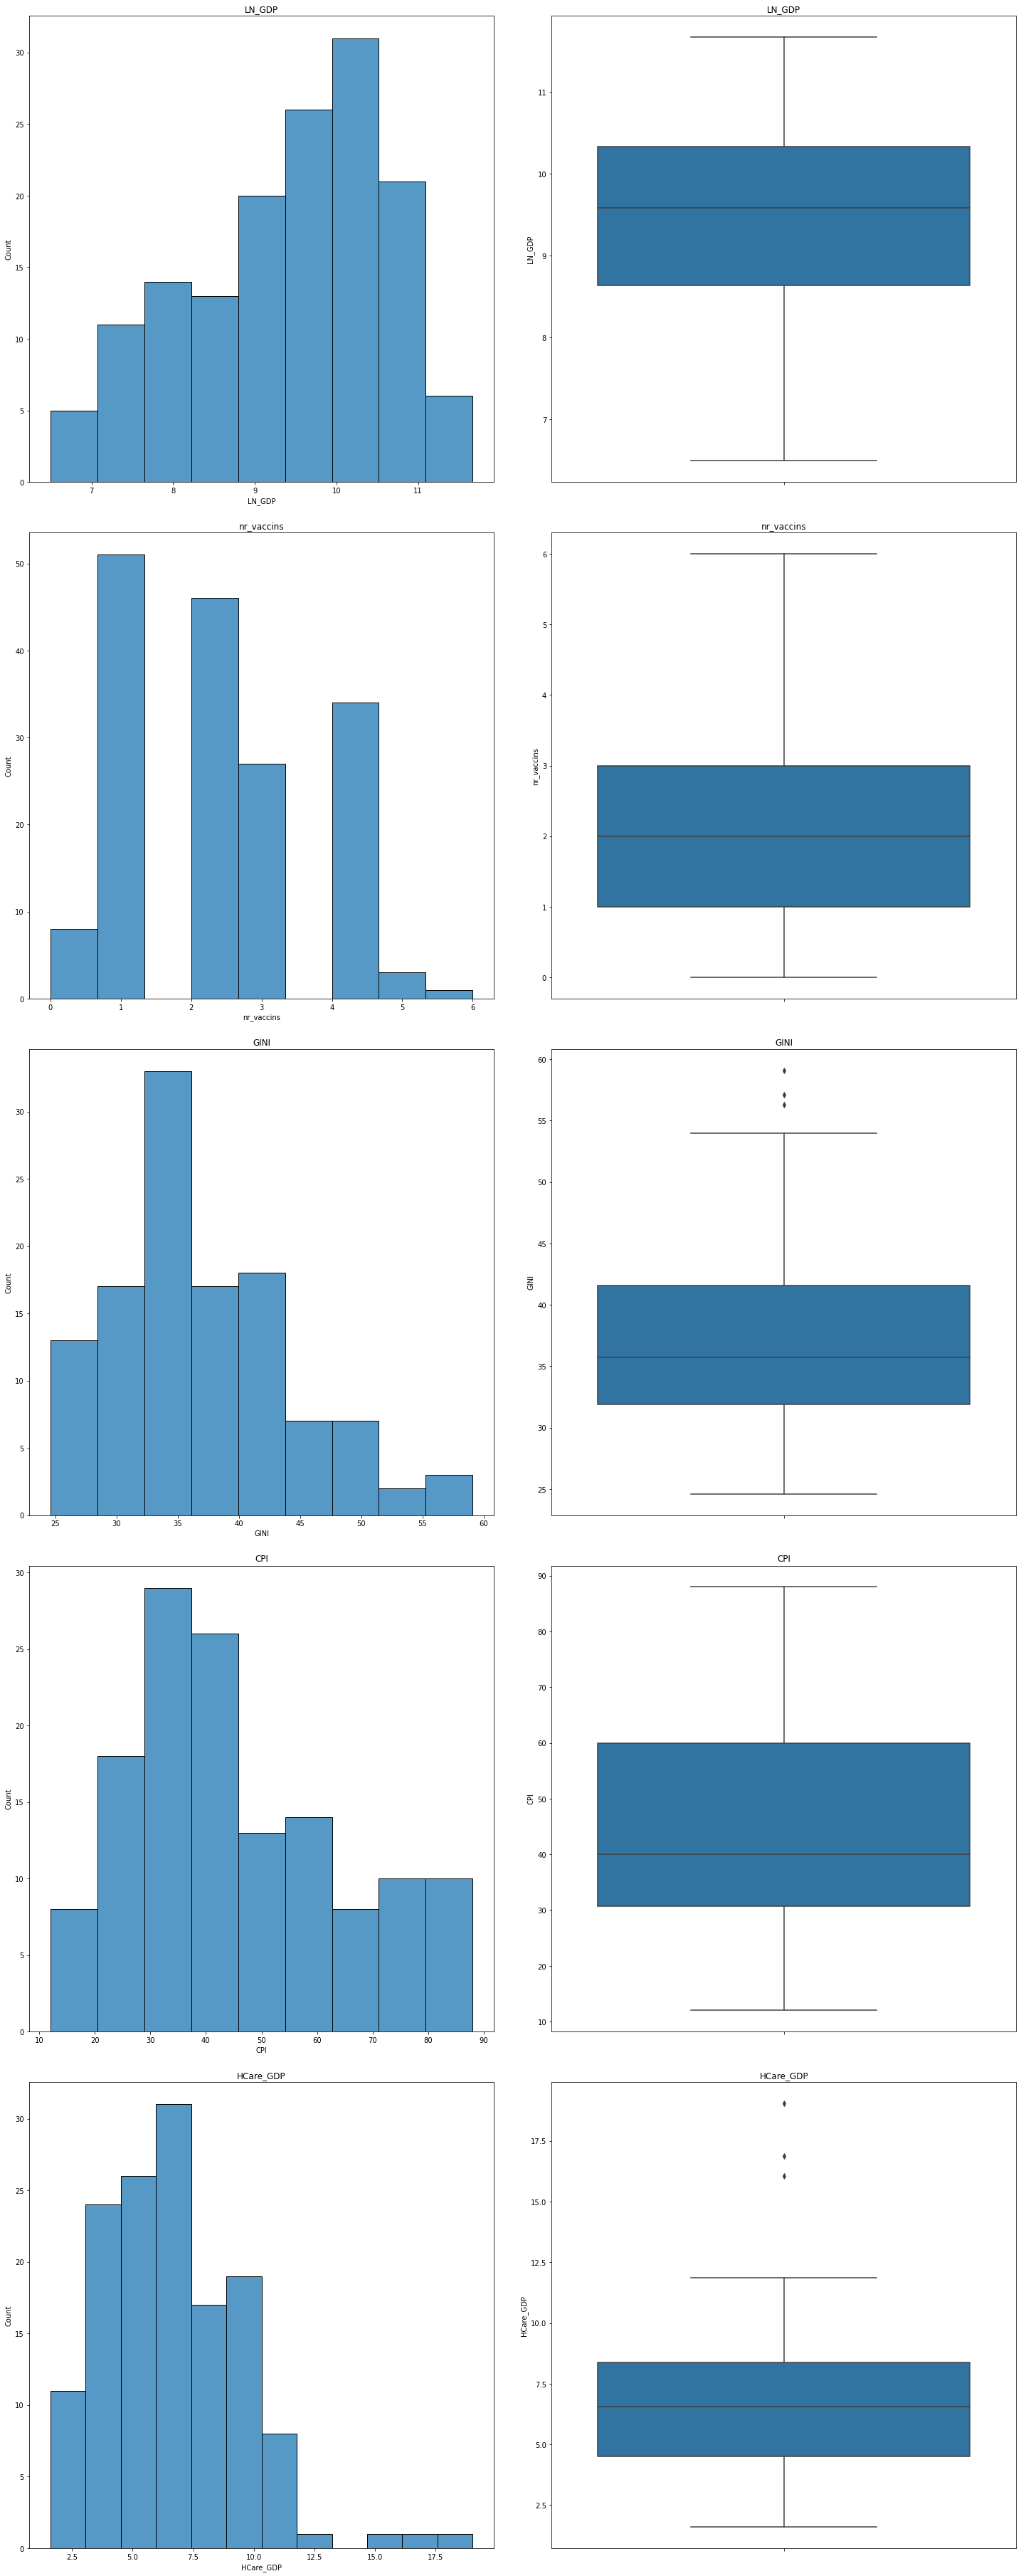

In [46]:
#FOR  QUICK ANALYSIS: look for outliers
variables = ['LN_GDP', 'nr_vaccins','GINI', 'CPI', 'HCare_GDP']

fig, ax = plt.subplots(5,2, figsize = (20,50))
fig.tight_layout(w_pad=5, h_pad=5)

for i in range(len(variables)):
    plt.sca(ax[i,0])
    sns.histplot(data=covid, x=variables[i]).set_title(variables[i])


    plt.sca(ax[i,1])
    sns.boxplot(data=covid, y=variables[i]).set_title(variables[i])

plt.show()

In [50]:
#The outliers are (see table below): Namibia, Zambia and Sao Tome and Principe.
covid[["country","ISO3", "GINI"]].sort_values("GINI", ascending=False).head(3)

,country,ISO3,GINI
138,Namibia,NAM,59.1
215,Zambia,ZMB,57.1
168,Sao Tome and Principe,STP,56.3


In [51]:
#These countries are Tuvalu, Marshall Islands and the USA (see table below). 
covid[["country","ISO3", "HCare_GDP"]].sort_values("HCare_GDP", ascending=False).head(3)

,country,ISO3,HCare_GDP
200,Tuvalu,TUV,19.047359
205,United States,USA,16.885298
173,Sierra Leone,SLE,16.063080


### Eyeball the correlation matrix
vaccination rate (per 100) is positively correlated with:
(LN)GDP; Hcare_GDP; CPI; Johnson, Moderna, Pfizer

vaccination rate (per 100) is negatively correlated with:
GINI, and to a lesser extent: Sputnik, Sinopharm, Sinovac and AstraZeneca

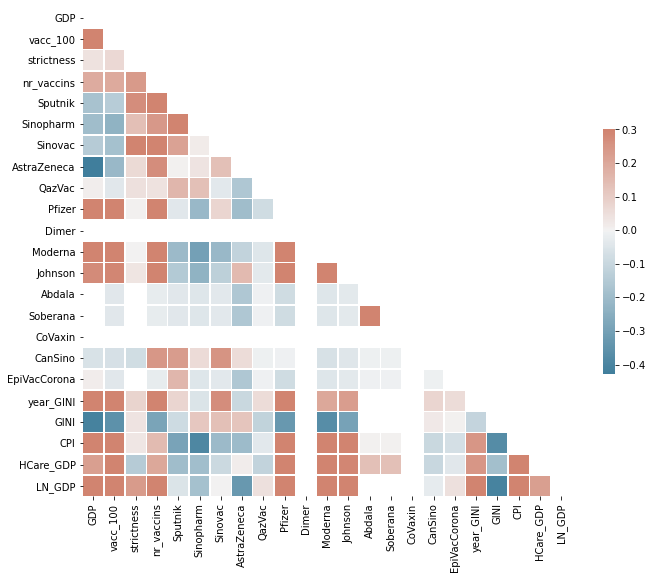

In [55]:
# Generate a large random dataset
rs = np.random.RandomState(33)

# Compute the correlation matrix
corr = covid.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

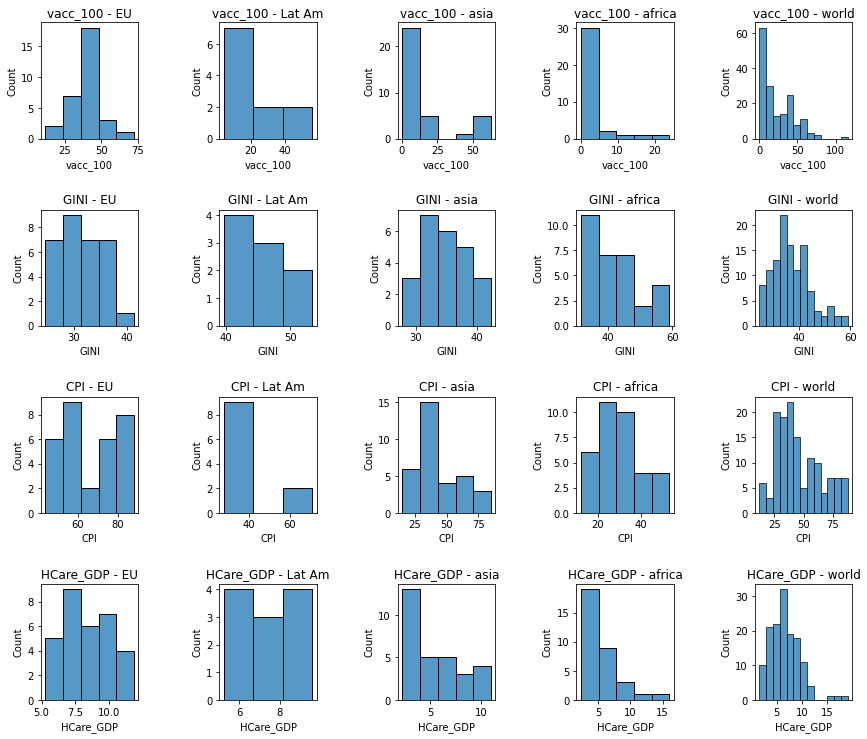

In [191]:
#check for some continents: is there variation in the other variables?

plot_this = ["vacc_100", "GINI", "CPI", "HCare_GDP"]

#regions/continents
lat_am_all = covid[(covid["continent"]=="South America")]
asia = covid[(covid["continent"]=="Asia")]
africa = covid[(covid["continent"]=="Africa")]
WE_EU=covid[(covid["region"]=="WE/EU")] #note: region not continent!

fig, ax = plt.subplots(4,5, figsize=(12,10))
fig.tight_layout(w_pad=5, h_pad=5)

for i in range(len(plot_this)):
    binnr = int(np.sqrt(len(WE_EU)))
    plt.sca(ax[i,0])
    sns.histplot(x=WE_EU[plot_this[i]], bins=binnr).set_title(plot_this[i] + " - EU")
    
    plt.sca(ax[i,1])
    binnr_latam = int(np.sqrt(len(lat_am_all)))
    sns.histplot(x=lat_am_all[plot_this[i]], bins=binnr_latam).set_title(plot_this[i] + " - Lat Am")
    
    plt.sca(ax[i,2])
    binnr_a = int(np.sqrt(len(asia)))
    sns.histplot(x=asia[plot_this[i]], bins=binnr_a).set_title(plot_this[i] + " - asia")
    
    plt.sca(ax[i,3])
    binnr_af = int(np.sqrt(len(africa)))
    sns.histplot(x=africa[plot_this[i]], bins=binnr_af).set_title(plot_this[i] + " - africa")
    
    plt.sca(ax[i,4])
    binnr_w = int(np.sqrt(len(covid)))
    sns.histplot(x=covid[plot_this[i]], bins=binnr_w).set_title(plot_this[i] + " - world")
#     sns.boxplot(data=WE_EU, y=plot_this[i]).set_title(plot_this[i] + " - EU")

plt.show()

## Start testing!

Questions: 
<ol>
    <li> Is the vaccination rate in Westn European countries different from the rest of the world </li>
    <li> Is the vaccination rate in Westn European countries different from North American countries </li>
    <li> Is the vaccination rate in Chile** different from other South American countries? </li>
    <li> Vaccination rates of Chile and Uruguay seem way above other South American countries, is this significant?</li>
    <li> Is the vaccination rate in Chile and Uruguay different from Western European coutries?</li> 
    <li> How do Uruguay and Chile compare to other South American countries on inequality (GINI), corruption (CPI), percentage GDP spent on healthcare and GDP per capita?</li>
    <li> Is the vaccination rate different in South American countries where Pfizer is/is not available?</li>
    <li> Is the vaccination rate different in South American countries where Sinovac and Sinopharm are/are not available?</li>
</ol>
  
  
** I take Chile as an example because I find South America an interesting continent, that's all. Do not that there are a lot of South American countries missing.

### Q1: Vaccination rate in Western European countries vs the rest
Question 1: is the mean vaccination rate of European countries different from the mean vaccination rate in other regions? 

H0: no, there is no signifiant difference in the mean vaccination rate in WE/EU region than in other regions in the world<br>
H1: yes, there is a signifiant difference in the mean vaccination rate in WE/EU region than in other regions in the world


In [21]:
# REMINDER: WE_EU = covid[covid["region"]== "WE/EU"]
rest = covid[covid["region"]!= "WE/EU"]

variable="vacc_100"
alpha = 0.025 #two sided testing 

st, p = ttest_ind(rest[variable], WE_EU[variable], equal_var=False)
print(st, p)
print("The H0 statement that the mean vaccination rate in Western European countries does not differ from the rest of the world is:", p>alpha)

-7.891081945004108 8.240136932270707e-12
The H0 statement that the mean vaccination rate in Western European countries does not differ from the rest of the world is: False


### Q2: Vaccination rate in Western Europe vs North America

Is the mean vaccination rate in North America different from the mean vaccination rate in the WE/EU?
 
H0: no, there is no signifiant difference in the mean vaccination rate in North America and WE/EU<br>
H1: yes, there is a signifiant difference in the mean vaccination rate in North America and WE/EU 

In [22]:
N_Am= covid[covid["continent"]=="North America"]
alpha = 0.025 #two sided testing 
st, p = ttest_ind(N_Am[variable], WE_EU[variable], equal_var=False)
print(st, p)
print("\nThe H0 statement that the mean vaccination rate in Western European countries does not differ from North American countries is:", p>alpha)

-1.6686690073128037 0.10572587933282568

The H0 statement that the mean vaccination rate in Western European countries does not differ from North American countries is: True


In [185]:
#create 95% confidence interval for population mean vaccination rate. See how much they overlap
from scipy.stats import t

all_lat_am = covid[covid["continent"]=="South America"]
conf_int_lat_am = t.interval(alpha=0.95, df=len(all_lat_am)-1, loc=np.mean(all_lat_am[variable]), scale=stats.sem(all_lat_am[variable]))
conf_int_WE_EU = t.interval(alpha=0.95, df=len(WE_EU)-1, loc=np.mean(WE_EU[variable]), scale=stats.sem(WE_EU[variable]))
conf_int_N_Am = t.interval(alpha=0.95, df=len(N_Am)-1, loc=np.mean(N_Am[variable]), scale=stats.sem(N_Am[variable]))

print(conf_int_lat_am)
print(conf_int_WE_EU)
print(conf_int_N_Am)

(9.868061558493478, 33.34337999994808)
(34.96324585279686, 42.84683248821696)
(22.218808018802847, 39.96365518466036)


### Q3: Vaccination rate in Chile verus the rest of Latin America
Chile is known as a relatively well developed country within Latin America. Lets look at their vaccination rate and compare it to the other Latin American countries.

In [186]:
Ch = covid[covid["country"]=="Chile"]
rest_lat_am = covid[(covid["continent"]=="South America") & (covid["country"]!="Chile")]
variable="vacc_100"
mean_ch = Ch[variable].mean() # vacc_rate in Chile: 55,96 Does this fall within the 95% most observed values of the latin american vaccination rate?

In [187]:
# 95% of the data lies within 2 STDEVs of the mean.
upper = rest_lat_am[variable].mean() + 2*rest_lat_am[variable].std()
lower = rest_lat_am[variable].mean() - 2*rest_lat_am[variable].std()

if mean_ch < lower or mean_ch > upper:
    print("Chile is a bit of an odd one out in South America: it's vaccination rate does not lie within the 95% most expected values")
else:
    print("Chile's vaccination rate is within 95% most expected vaccination rates of southern america")

Chile is a bit of an odd one out in South America: it's vaccination rate does not lie within the 95% most expected values


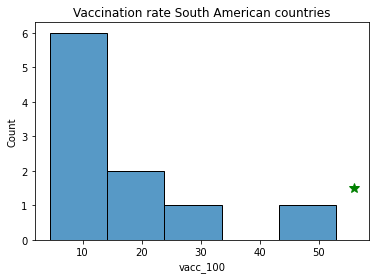

In [188]:
#confirm this by plotting
sns.histplot(rest_lat_am[variable])
plt.plot([Ch[variable]], [1.5], '*', markersize = 10, lw=4, color='g') #Chile as an asterix
plt.title("Vaccination rate South American countries")
plt.show()

### Q4: The plot shows another country with a relatively high vaccination rate. Check out which country this is and check the vaccination rates in these countries are significantly higher than in other south amercian countries.

In [27]:
rest_lat_am.sort_values(by=variable, ascending=False) #Uruguay is the other country with high vacc_100.

,country,ISO3,continent,region,system,GDP,vacc_100,strictness,nr_vaccins,Sputnik,Sinopharm,Sinovac,AstraZeneca,QazVac,Pfizer,Dimer,Moderna,Johnson,Abdala,Soberana,CoVaxin,CanSino,EpiVacCorona,year_GINI,GINI,CPI,HCare_GDP,LN_GDP
206,Uruguay,URY,South America,AME,presidential republic,20551.409,52.928571,62.04,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,39.7,71.0,9.202700,9.930685
85,Guyana,GUY,South America,AME,parliamentary republic,7435.047,25.920000,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,41.0,5.936093,8.913960
27,Brazil,BRA,South America,AME,federal presidential republic,14103.452,21.742857,NaN,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,53.4,38.0,9.514387,9.554175
7,Argentina,ARG,South America,AME,presidential republic,18933.907,21.562857,81.48,3.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,42.9,42.0,9.624540,9.848710
41,Colombia,COL,South America,AME,presidential republic,13254.949,13.688333,74.07,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,51.3,39.0,7.639800,9.492126
186,Suriname,SUR,South America,AME,presidential republic,13767.119,11.907500,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,38.0,7.969472,9.530038
24,Bolivia,BOL,South America,AME,presidential republic,6885.829,11.697143,NaN,4.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,41.6,31.0,6.301026,8.837221
57,Ecuador,ECU,South America,AME,presidential republic,10581.936,9.180000,NaN,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,45.7,39.0,8.136465,9.266904
156,Peru,PER,South America,AME,presidential republic,12236.706,8.638333,75.93,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,41.5,38.0,5.238002,9.412195
155,Paraguay,PRY,South America,AME,presidential republic,8827.010,4.433333,NaN,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,45.7,28.0,6.654511,9.085572


H0: no, the mean vaccination rate in Chile and Uruguay is not significantly higher than in the other South American countries<br>
H1: yes, the mean vaccination rate in Chile and Uruguay is significantly higher than in the other South American countries 


In [28]:
CH_UR = covid[(covid["country"]=="Chile")|(covid["country"]=="Uruguay")] #group chile and Uruguay
NO_CH_UR =covid[(covid["continent"]=="South America")&(covid["country"]!="Chile")&(covid["country"]!="Uruguay")] #latin america without chile and uruguay
NO_CH_UR

,country,ISO3,continent,region,system,GDP,vacc_100,strictness,nr_vaccins,Sputnik,Sinopharm,Sinovac,AstraZeneca,QazVac,Pfizer,Dimer,Moderna,Johnson,Abdala,Soberana,CoVaxin,CanSino,EpiVacCorona,year_GINI,GINI,CPI,HCare_GDP,LN_GDP
7,Argentina,ARG,South America,AME,presidential republic,18933.907,21.562857,81.48,3.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,42.9,42.0,9.624540,9.848710
24,Bolivia,BOL,South America,AME,presidential republic,6885.829,11.697143,NaN,4.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,41.6,31.0,6.301026,8.837221
27,Brazil,BRA,South America,AME,federal presidential republic,14103.452,21.742857,NaN,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,53.4,38.0,9.514387,9.554175
41,Colombia,COL,South America,AME,presidential republic,13254.949,13.688333,74.07,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,51.3,39.0,7.639800,9.492126
57,Ecuador,ECU,South America,AME,presidential republic,10581.936,9.180000,NaN,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,45.7,39.0,8.136465,9.266904
85,Guyana,GUY,South America,AME,parliamentary republic,7435.047,25.920000,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,41.0,5.936093,8.913960
155,Paraguay,PRY,South America,AME,presidential republic,8827.010,4.433333,NaN,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,45.7,28.0,6.654511,9.085572
156,Peru,PER,South America,AME,presidential republic,12236.706,8.638333,75.93,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,41.5,38.0,5.238002,9.412195
186,Suriname,SUR,South America,AME,presidential republic,13767.119,11.907500,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,38.0,7.969472,9.530038


In [29]:
alhpa = 0.05
st, p = ttest_ind(CH_UR[variable], NO_CH_UR[variable], equal_var=False)
print("For", variable, "the statistic and p-value are:", round(st,3), "and", round(p,3))

if st>0:
    print("\nThis means that the statement that Uruguay and Chile have significantly higher vaccination rates than the other countries is:", p<alpha, '\n')
else:
    print("\nThis means that the statement that Uruguay and Chile have significantly higher vaccination rates than the other countries is: False.")

For vacc_100 the statistic and p-value are: 14.173 and 0.0

This means that the statement that Uruguay and Chile have significantly higher vaccination rates than the other countries is: True 



### Q5: Is the vaccination rate in Chile and Uruguay different from Western European countries?
Chile and Uruguay do well compared to other South American countries, how do they compare to European countries?<br>
H0: no they are not different. <br>
H1: yes they are sign. different.

In [30]:
alpha = 0.025

st, p = ttest_ind(CH_UR[variable], WE_EU[variable], equal_var=False)

print("For", variable, "the statistic and p-value are:", st, "and", p)
print("\nThis means that the statement that the vaccination rate in Uruguay and Chile significantly differs from European countries is:", p<alpha)

For vacc_100 the statistic and p-value are: 6.329541557429858 and 0.0006000034938116784

This means that the statement that the vaccination rate in Uruguay and Chile significantly differs from European countries is: True


### Q6: Inequality, corruption, percentage GDP spent on healthcare and GDP per capita in Uruguay&Chile versus the other South American countries

The plot shows another country with a relatively high vaccination rate. Check out which country this is and check how these to countries compare to the others on:
- GINI;
- CPI;
- % GDP spent on healthcare;
- GDP/capita

for all:
H0: Chile and Uruguay do not differ significantly from the other south american countries on the tested variable
H1: Chile and Uruguay do differ significantly from the other south american countries on the tested variable

In [31]:
variable = ["GINI", "CPI", "HCare_GDP", "LN_GDP"]
alpha = 0.025 #two-sided testing
for i in range(len(variable)):
    st, p = ttest_ind(CH_UR[variable[i]], NO_CH_UR[variable[i]], equal_var=False)
    print("For", variable[i], "the statistic and p-value are:", round(st,3), "and", round(p,3))
    print("This means that the statement that Uruguay and Chile differ from the other countries on", variable[i], "is:", p<alpha, '\n')

For GINI the statistic and p-value are: nan and nan
This means that the statement that Uruguay and Chile differ from the other countries on GINI is: False 

For CPI the statistic and p-value are: 12.659 and 0.003
This means that the statement that Uruguay and Chile differ from the other countries on CPI is: True 

For HCare_GDP the statistic and p-value are: 3.361 and 0.01
This means that the statement that Uruguay and Chile differ from the other countries on HCare_GDP is: True 

For LN_GDP the statistic and p-value are: 5.398 and 0.001
This means that the statement that Uruguay and Chile differ from the other countries on LN_GDP is: True 



In [32]:
#Whats going on with the GINI?
covid[covid["continent"]=="South America"].sort_values(by="GINI") #Two NaN-values

,country,ISO3,continent,region,system,GDP,vacc_100,strictness,nr_vaccins,Sputnik,Sinopharm,Sinovac,AstraZeneca,QazVac,Pfizer,Dimer,Moderna,Johnson,Abdala,Soberana,CoVaxin,CanSino,EpiVacCorona,year_GINI,GINI,CPI,HCare_GDP,LN_GDP
206,Uruguay,URY,South America,AME,presidential republic,20551.409,52.928571,62.04,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,39.7,71.0,9.202700,9.930685
156,Peru,PER,South America,AME,presidential republic,12236.706,8.638333,75.93,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,41.5,38.0,5.238002,9.412195
24,Bolivia,BOL,South America,AME,presidential republic,6885.829,11.697143,NaN,4.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,41.6,31.0,6.301026,8.837221
7,Argentina,ARG,South America,AME,presidential republic,18933.907,21.562857,81.48,3.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,42.9,42.0,9.624540,9.848710
39,Chile,CHL,South America,AME,presidential republic,22767.037,55.964000,NaN,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,44.4,67.0,9.140513,10.033069
57,Ecuador,ECU,South America,AME,presidential republic,10581.936,9.180000,NaN,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,45.7,39.0,8.136465,9.266904
155,Paraguay,PRY,South America,AME,presidential republic,8827.010,4.433333,NaN,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,45.7,28.0,6.654511,9.085572
41,Colombia,COL,South America,AME,presidential republic,13254.949,13.688333,74.07,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,51.3,39.0,7.639800,9.492126
27,Brazil,BRA,South America,AME,federal presidential republic,14103.452,21.742857,NaN,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,53.4,38.0,9.514387,9.554175
85,Guyana,GUY,South America,AME,parliamentary republic,7435.047,25.920000,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,41.0,5.936093,8.913960


In [33]:
#Try again, now without the two NANs
NO_NAN = NO_CH_UR[(NO_CH_UR["ISO3"]!="GUY")&(NO_CH_UR["ISO3"]!="SUR")]


variable = ["GINI"]
for i in range(len(variable)):
    st, p = ttest_ind(CH_UR[variable[i]], NO_NAN[variable[i]], equal_var=False)
    print("For", variable[i], "the statistic and p-value are:", round(st,3), "and", round(p,3))
    print("This means that the statement that Uruguay and Chile differ from the other countries on", variable[i], "is:", p<0.025, '\n')

For GINI the statistic and p-value are: -1.346 and 0.294
This means that the statement that Uruguay and Chile differ from the other countries on GINI is: False 



In [34]:
#beyond the scope of the assignment.. but still nice to look at a multiple regression
lat_am = covid[(covid["continent"]=="South America")]

est = smf.ols(data=lat_am, formula = 'vacc_100 ~ HCare_GDP + LN_GDP + GINI + CPI').fit() 
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               vacc_100   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     16.71
Date:                Wed, 30 Jun 2021   Prob (F-statistic):            0.00921
Time:                        15:28:44   Log-Likelihood:                -25.882
No. Observations:                   9   AIC:                             61.76
Df Residuals:                       4   BIC:                             62.75
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9528    101.312      0.009      0.9

C:\Users\jetsa\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Basically too little observations, but interesting to see that still >85% R2 and to see that the only significant variable within this group of countries the is corruption. Just for fun, also try this with the whole world see if the models return something similar..

In [35]:
est = smf.ols(data=covid, formula = 'vacc_100 ~ HCare_GDP + LN_GDP + GINI + CPI').fit() 
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               vacc_100   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     38.37
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           9.29e-20
Time:                        15:28:44   Log-Likelihood:                -429.76
No. Observations:                 110   AIC:                             869.5
Df Residuals:                     105   BIC:                             883.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -65.3788     16.240     -4.026      0.0

Pretty different: lower R2, GDP had highest coefficient. Healthcare_GDP is significant too, and corruption is no longer.

### Q7: Available vaccins versus vaccination rate in South American countries
Not all vaccins are available in all Latin American countries. Lets see if countries where Pfizer is available have higher vaccination rates.

H0: no, no sign differences <br>
H1: yes, higher vaccination rate when pfizer is available

In [36]:
# REMINDER: lat_am = covid[(covid["continent"]=="South America")]

lat_am.iloc[:, 9:23].sum().sort_values(ascending=False)


AstraZeneca     11.0
Pfizer           7.0
Sinovac          6.0
Sinopharm        4.0
Sputnik          4.0
EpiVacCorona     0.0
CanSino          0.0
CoVaxin          0.0
Soberana         0.0
Abdala           0.0
Johnson          0.0
Moderna          0.0
Dimer            0.0
QazVac           0.0
dtype: float64

#### Pfizer effect?

There are five vaccins available in Latin America. AstraZeneca is everywhere, but Pfizer is not. Check if the vaccination rate in Latin American countries with and without Pfizer differs.

In [190]:
No_Pf = lat_am[lat_am["Pfizer"]==0]
Pf = lat_am[lat_am["Pfizer"]==1]
alpha=0.05 #one sided testing
variable="vacc_100"
st, p = ttest_ind(No_Pf[variable], Pf[variable], equal_var=False)
print(st, p)

if st>0 and p<alpha:
    print("The statement that the vaccination rate in countries where Pfizer is avaible is not higher than in the non-Pfizer countries is:", p>alpha)
else:
    print("The statement that the vaccination rate in countries where Pfizer is avaible is not higher than in the non-Pfizer countries is: True")

-0.9654638454310587 0.3599014284441556
The statement that the vaccination rate in countries where Pfizer is avaible is not higher than in the non-Pfizer countries is: True


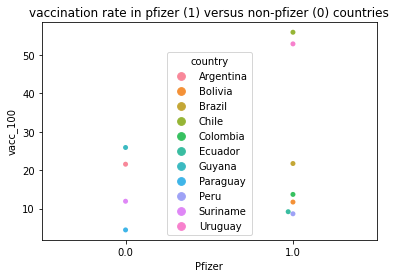

In [38]:
#See what this looks like - plot 1
sns.swarmplot(data=lat_am, x="Pfizer", y="vacc_100", hue="country")
plt.title("vaccination rate in pfizer (1) versus non-pfizer (0) countries")
plt.show()

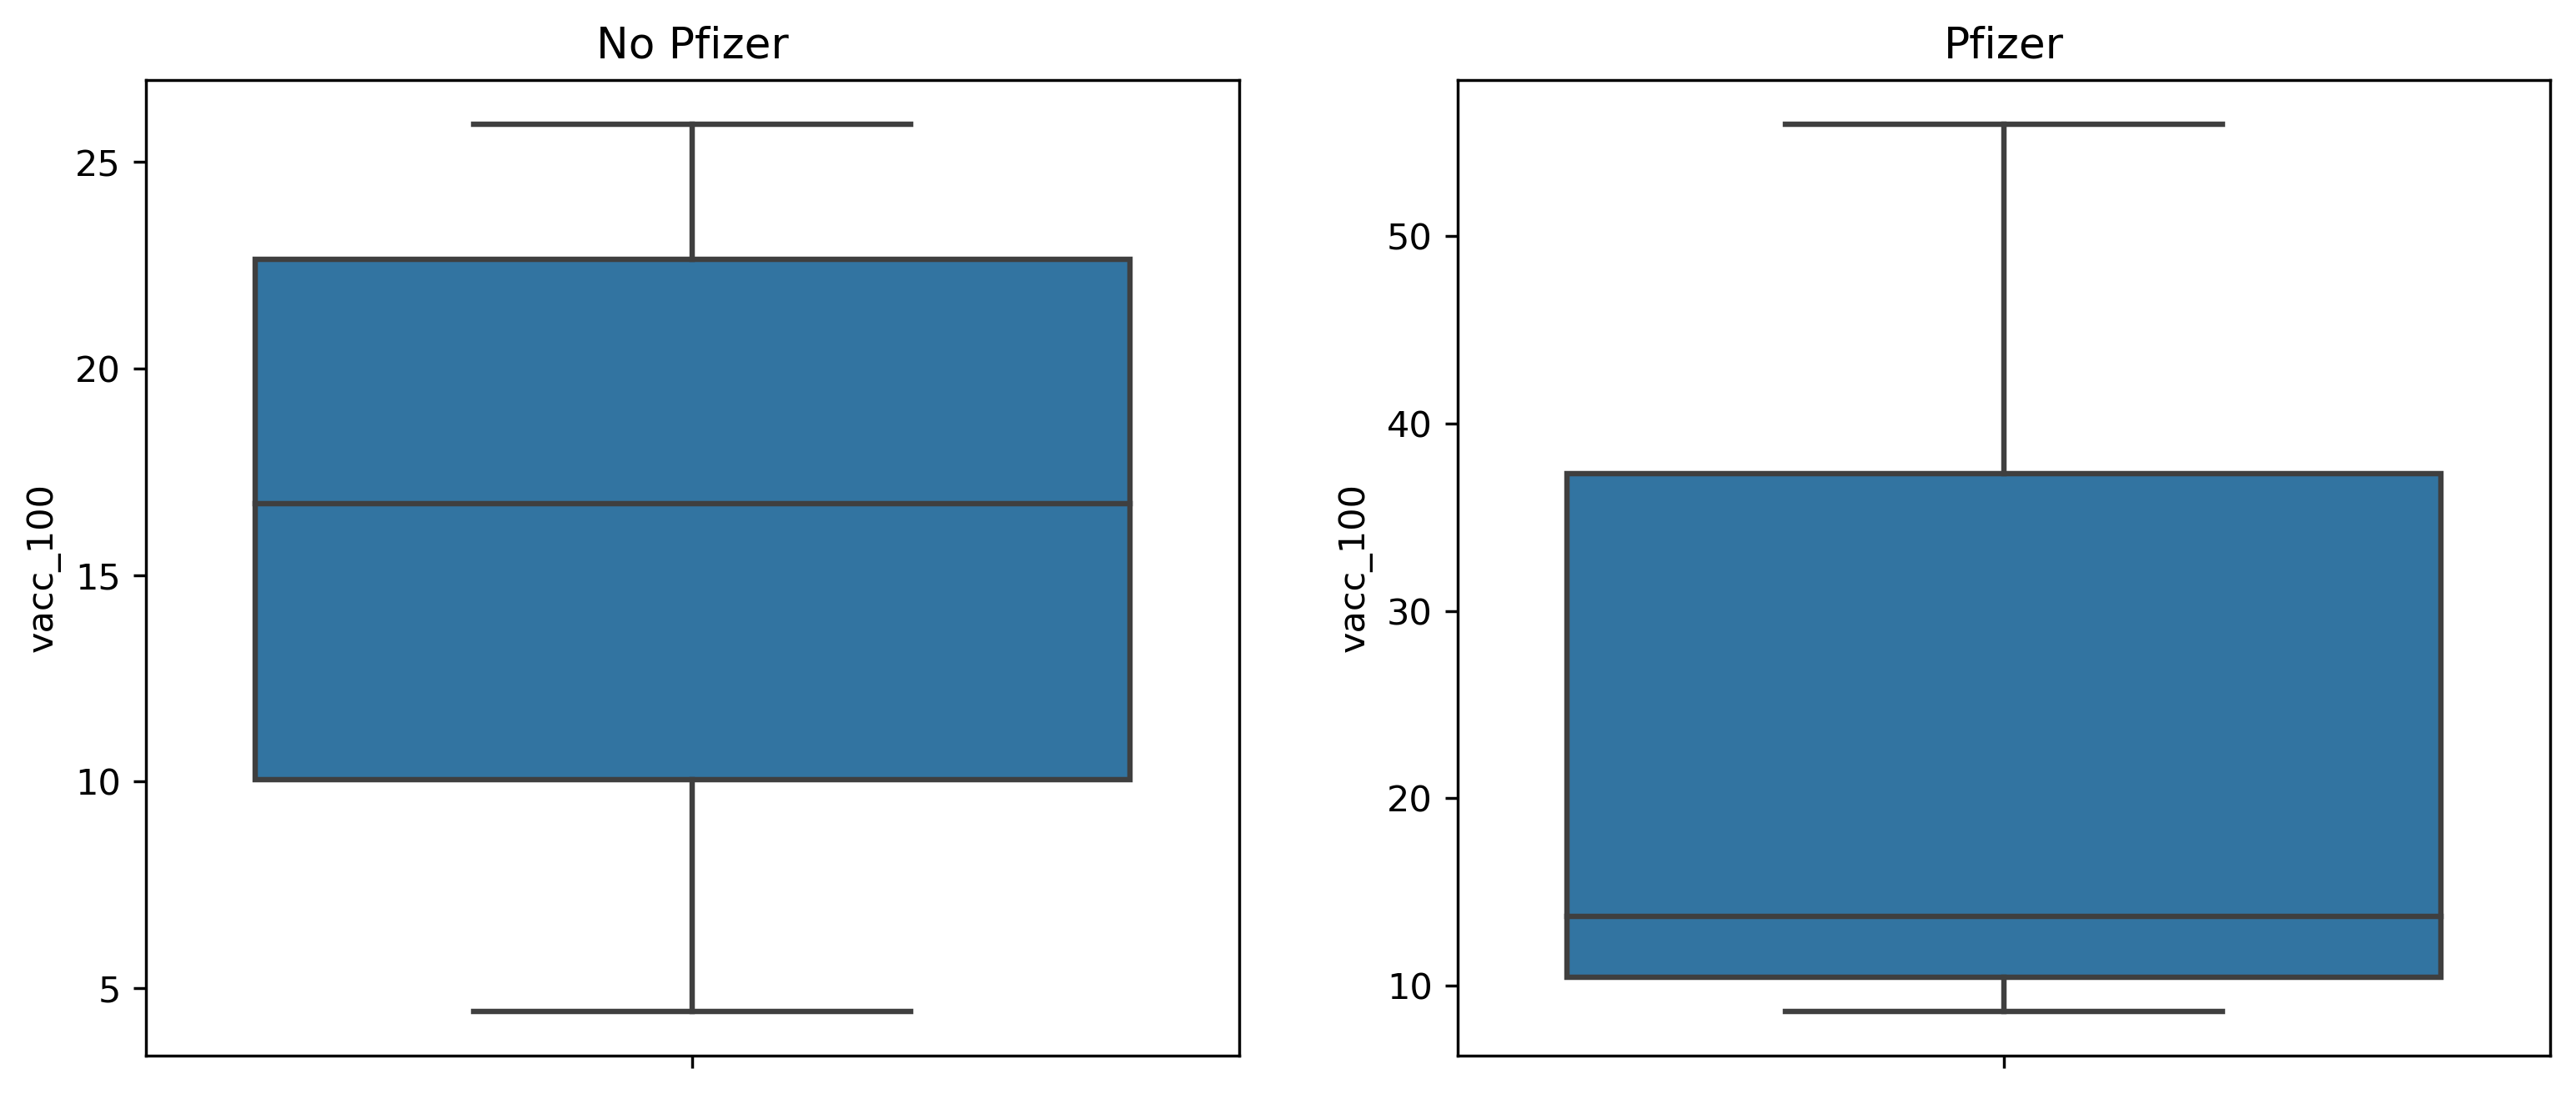

In [193]:
#see what this looks like - plot 2
fig, ax = plt.subplots(1,2, figsize=(12,5), dpi=310)

plt.sca(ax[0])
sns.boxplot(data=No_Pf, y="vacc_100").set_title("No Pfizer")

plt.sca(ax[1])
sns.boxplot(data=Pf, y="vacc_100").set_title("Pfizer")
plt.show()

#### Sinovac/pharm effect?

H0: no sign differences<br>
H1: sign different

In [40]:
No_Sinos = lat_am[(lat_am["Sinovac"]==0)&(lat_am["Sinopharm"]==0)]
Sinos = lat_am[(lat_am["Sinovac"]==1)|(lat_am["Sinopharm"]==1)]


variable="vacc_100"
st, p = ttest_ind(No_Sinos[variable], Sinos[variable], equal_var=False)
print(st, p)

print("The statement that Sinopharm or Sinovac is not correlated with different vaccination rates in South American countries is:", p>0.025)

-0.34705660134148697 0.7508739922162013
The statement that Sinopharm or Sinovac is not correlated with different vaccination rates in South American countries is: True


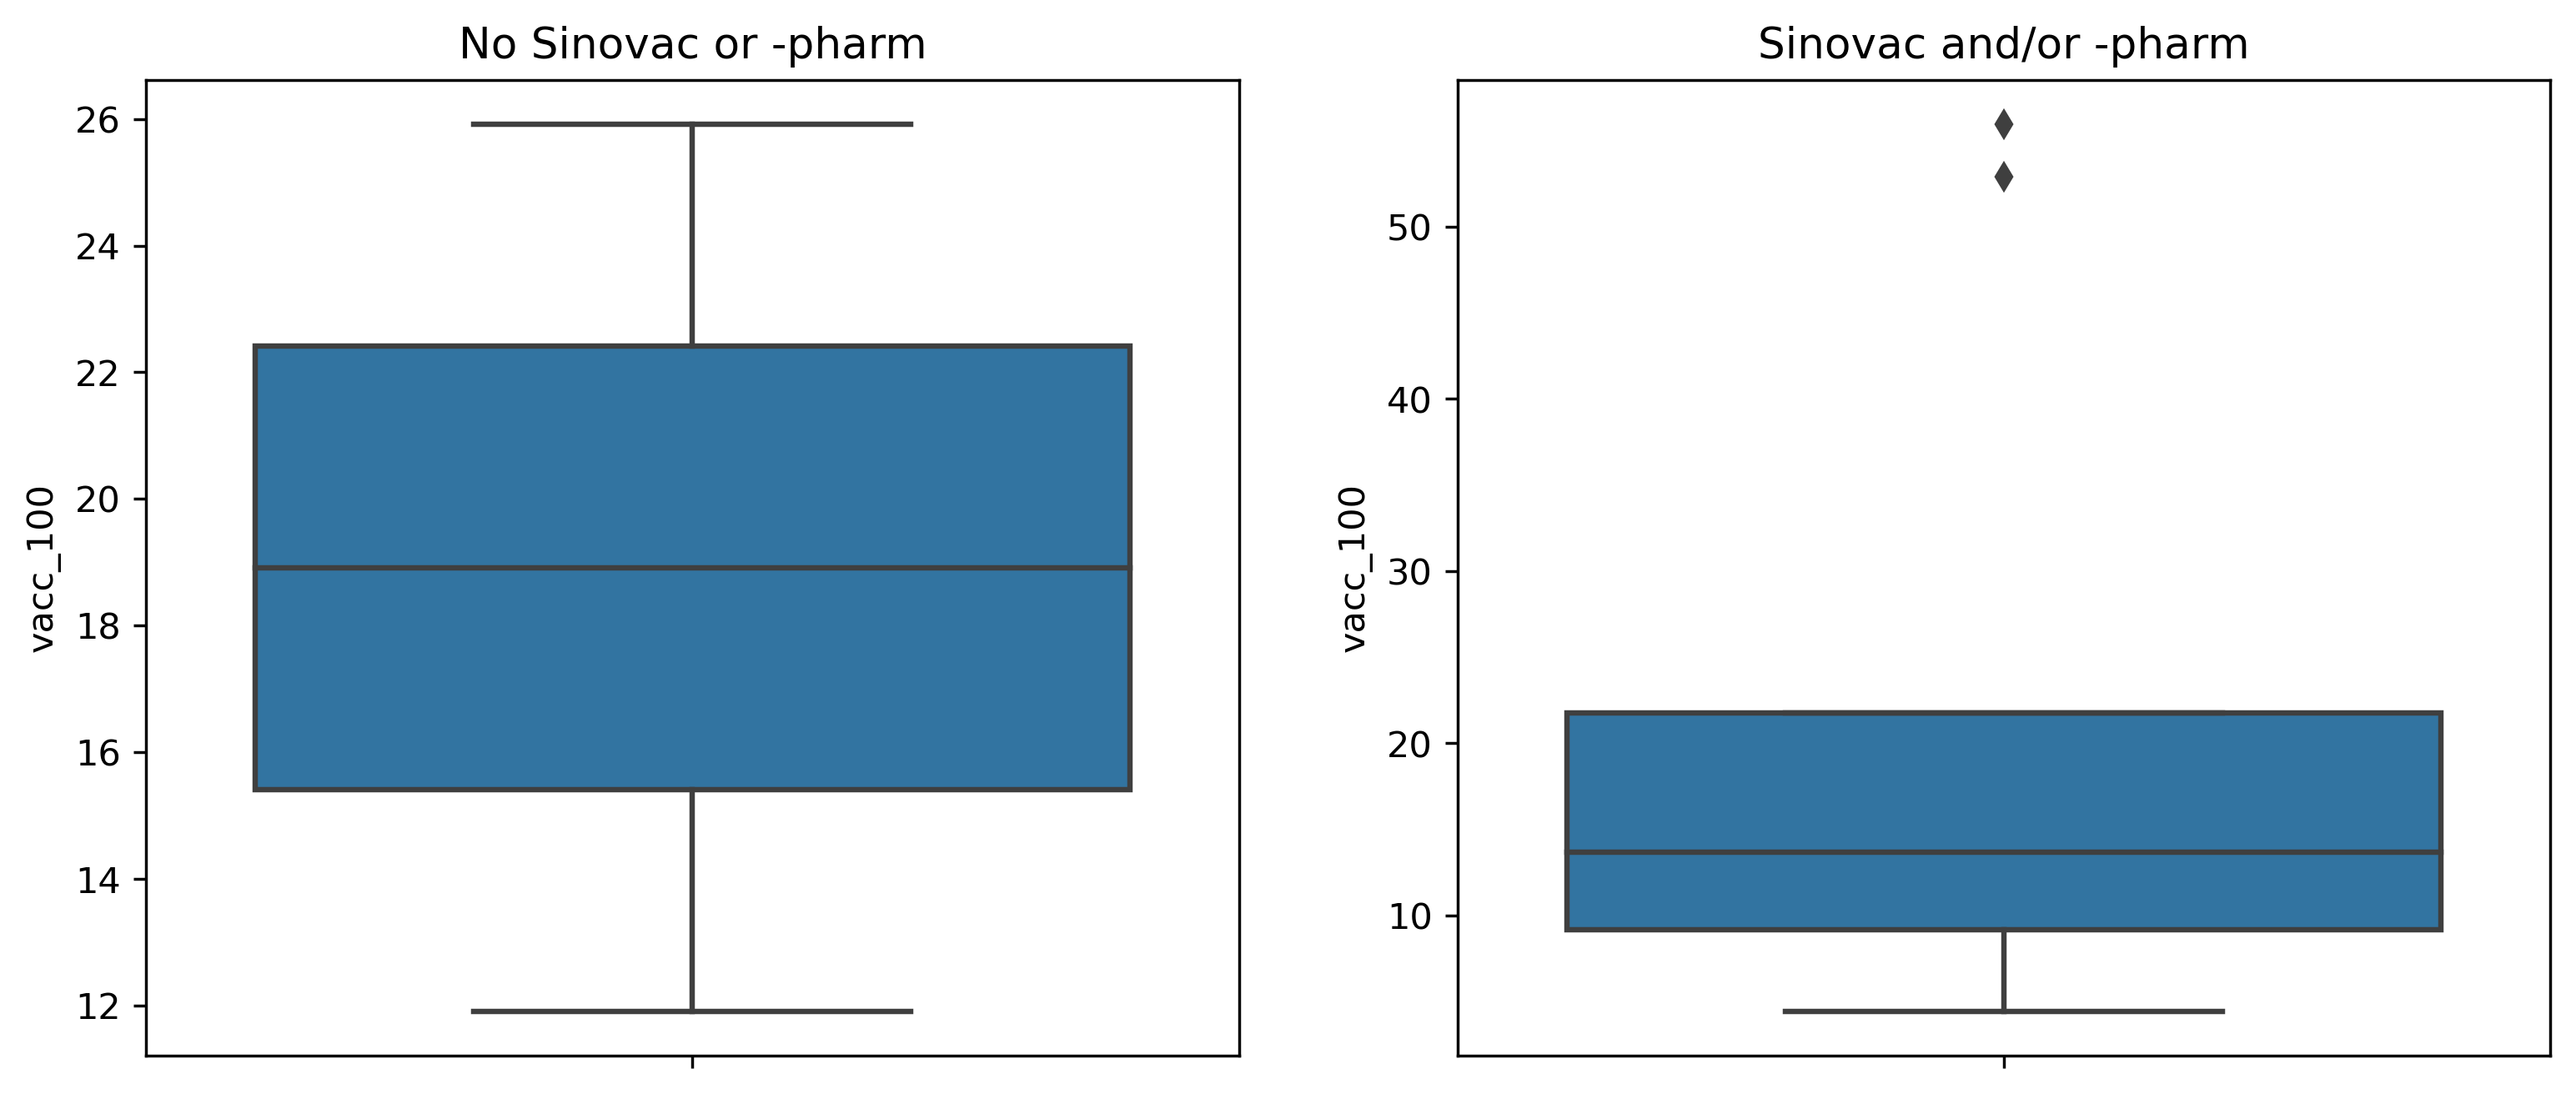

In [192]:
#see what this looks like
fig, ax = plt.subplots(1,2, figsize=(12,5), dpi=310)

plt.sca(ax[0])
sns.boxplot(data=No_Sinos, y="vacc_100").set_title("No Sinovac or -pharm")

plt.sca(ax[1])
sns.boxplot(data=Sinos, y="vacc_100").set_title("Sinovac and/or -pharm")
plt.show()

In [42]:
#check: are Chile and Uruguay the outliers? Yes
Sinos.sort_values(by="vacc_100", ascending=False) 

,country,ISO3,continent,region,system,GDP,vacc_100,strictness,nr_vaccins,Sputnik,Sinopharm,Sinovac,AstraZeneca,QazVac,Pfizer,Dimer,Moderna,Johnson,Abdala,Soberana,CoVaxin,CanSino,EpiVacCorona,year_GINI,GINI,CPI,HCare_GDP,LN_GDP
39,Chile,CHL,South America,AME,presidential republic,22767.037,55.964000,NaN,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,44.4,67.0,9.140513,10.033069
206,Uruguay,URY,South America,AME,presidential republic,20551.409,52.928571,62.04,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,39.7,71.0,9.202700,9.930685
27,Brazil,BRA,South America,AME,federal presidential republic,14103.452,21.742857,NaN,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,53.4,38.0,9.514387,9.554175
7,Argentina,ARG,South America,AME,presidential republic,18933.907,21.562857,81.48,3.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,42.9,42.0,9.624540,9.848710
41,Colombia,COL,South America,AME,presidential republic,13254.949,13.688333,74.07,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,51.3,39.0,7.639800,9.492126
24,Bolivia,BOL,South America,AME,presidential republic,6885.829,11.697143,NaN,4.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,41.6,31.0,6.301026,8.837221
57,Ecuador,ECU,South America,AME,presidential republic,10581.936,9.180000,NaN,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,45.7,39.0,8.136465,9.266904
156,Peru,PER,South America,AME,presidential republic,12236.706,8.638333,75.93,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,41.5,38.0,5.238002,9.412195
155,Paraguay,PRY,South America,AME,presidential republic,8827.010,4.433333,NaN,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,45.7,28.0,6.654511,9.085572


### Conclusions

<ol>
    <li> The vaccination rate in Western European countries is significantly different from the rest of the world </li>
    <li> The vaccination rate in Western European countries does not sign. differ from North American countries </li>
    <li> The vaccination rate in Chile is in the 5% extreme values of other South American countries </li>
    <li> Vaccination rates of Chile and Uruguay seem way above other South American countries are significantly higher than in the other latin american countries</li>
    <li> The vaccination rate in Chile and Uruguay is significantly different from Western European coutries</li> 
    <li> Uruguay and Chile have significantly different corruption (CPI), percentage GDP spent on healthcare and GDP per capita than other South American countries. Inequality (GINI) does not differ significantly</li>
    <li> The vaccination rate is not significantly different in South American countries where Pfizer is/is not available</li>
    <li> The vaccination rate is not significantly different in South American countries where Sinovac and Sinopharm are/are not available</li>
</ol>

# THE END